In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.utils.set_random_seed(3)

In [2]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import time

# Loading data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# train_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/train.npz"
# test_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/test.npz"
# model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/cvae.h5"
# log_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/logs/cvae"
train_path = "data/train.npz"
test_path = "data/test.npz"
model_path = "models/cvae.h5"
#log_path = "logs/cvae"

In [5]:
train_data = np.load(train_path)
X_train = train_data["arr_0"]
y_train = train_data["arr_1"]
X_train.shape, y_train.shape

((10000, 128, 128, 1), (10000,))

In [6]:
test_data = np.load(test_path)
X_test = test_data["arr_0"]
y_test = test_data["arr_1"]
X_test.shape, y_test.shape

((400, 128, 128, 1), (400,))

Normalize

In [7]:
X_train = X_train / 255.
X_test = X_test / 255.

# Model

## Encoder

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
latent_dim = 32
n_classes = 2
images_shape = X_train[0].shape # (128, 128, 1)

# Encoder
encoder_input = keras.Input(shape=images_shape)
label_input = keras.Input(shape=())
label = layers.Embedding(n_classes, np.prod(images_shape), input_length=1)(label_input)
label = layers.Reshape(images_shape)(label)

x = keras.layers.Concatenate()([encoder_input, label])

x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

shape_before_flattening = K.int_shape(x)[1:]
print(shape_before_flattening)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x) 
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([encoder_input, label_input], [z_mean, z_log_var, z], name="encoder") 
#we need to output also z_mean and z_log_var to calculate the kl loss
encoder.summary()

(8, 8, 256)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16384)        32768       ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 128, 128, 1)  0           ['embedding[0][

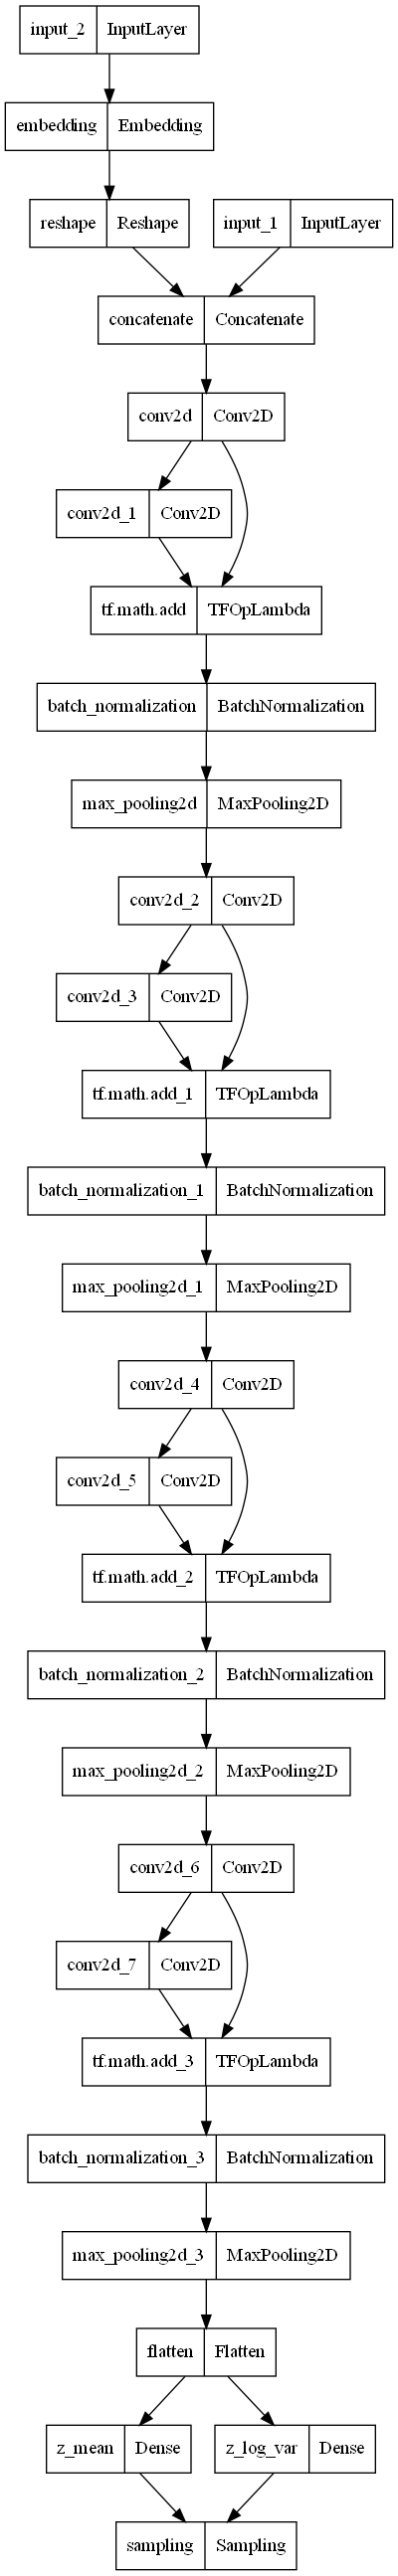

In [10]:
plot_model(encoder)

In [11]:
# Decoder
latent_input = keras.Input(shape=(latent_dim,), name='decoder_input')
label = layers.Embedding(n_classes, latent_dim, input_length=1)(label_input)
x = layers.Concatenate()([latent_input, label])
x = layers.Dense(np.prod(shape_before_flattening))(x)
x = layers.Reshape(shape_before_flattening)(x)

x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = keras.Model([latent_input, label_input], decoded, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 32)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32)           64          ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64)           0           ['decoder_input[0][0]',          
                                                                  'embedding_1[0][0]']      

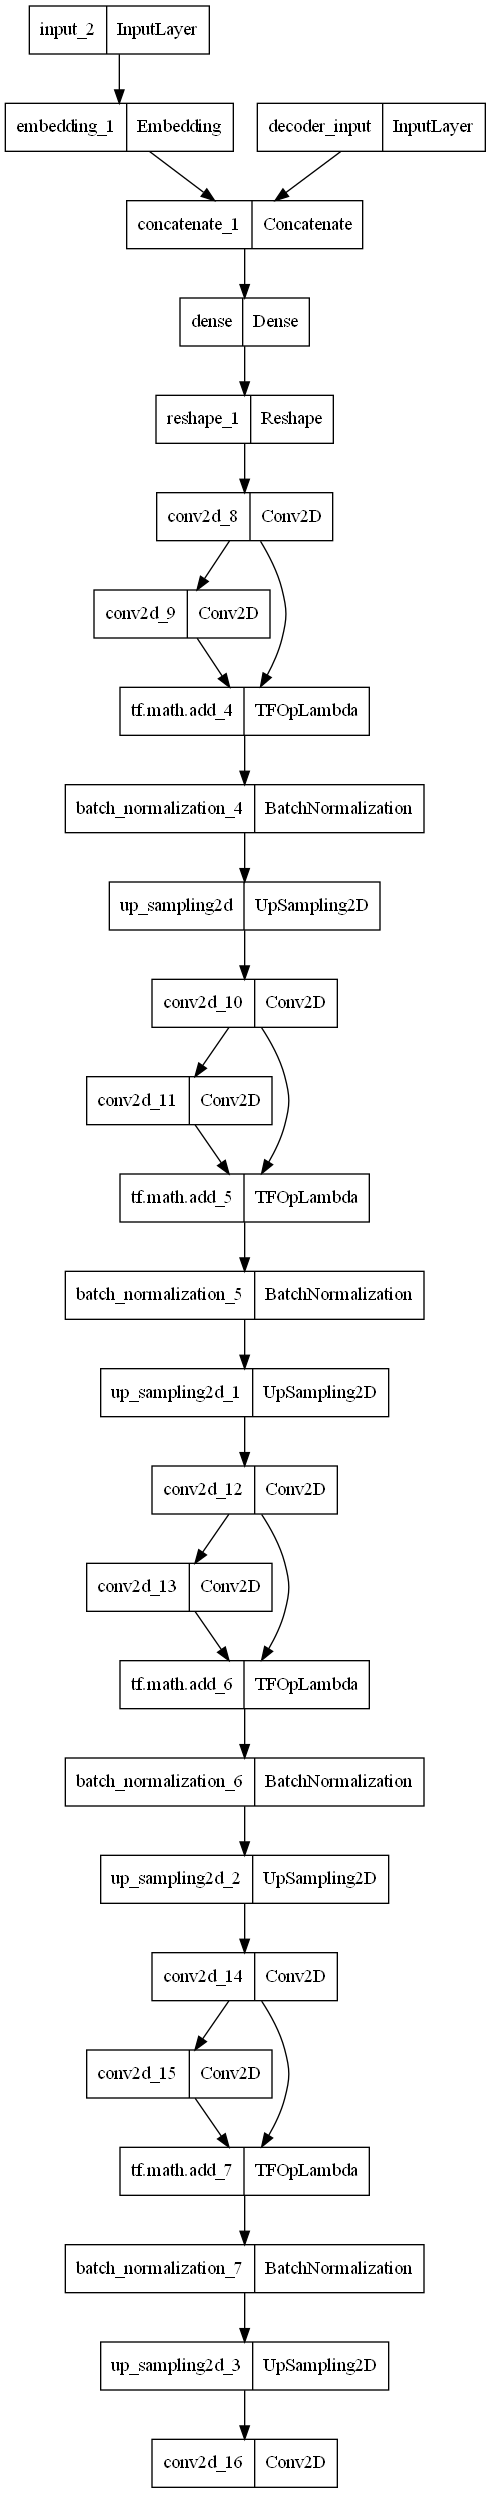

In [12]:
plot_model(decoder)

In [13]:
# VAE
encoder_input = keras.Input(shape=images_shape)
label_input = keras.Input(shape=())
z_mean, z_log_var, z = encoder([encoder_input, label_input])
decoded = decoder([z, label_input])
vae = keras.Model([encoder_input, label_input], decoded, name="vae")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         2255296     ['input_3[0][0]',                
                                 (None, 32),                      'input_4[0][0]']                
                                 (None, 32)]                                                    

In [14]:
class VAETrainer(keras.Model):
    def __init__(self, encoder, decoder, beta=1., **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data): 
        with tf.GradientTape() as tape: #calculate loss and record
            x, y = data
            z_mean, z_log_var, z = self.encoder([x, y])
            reconstruction = self.decoder([z, y])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(x, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta

        grads = tape.gradient(total_loss, self.trainable_weights) #backpropagation
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) #update weights

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data): #validation step
        x_test, y_test = data
        z_mean, z_log_var, z = self.encoder([x_test, y_test])
        reconstruction = self.decoder([z, y_test])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(x_test, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:
vae_trainer = VAETrainer(encoder, decoder, beta=4, name="vae")
optimizer = keras.optimizers.Adam(0.001)
vae_trainer.compile(optimizer=optimizer)

In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.1, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_path)

In [17]:
init_time = time.time()
logs = vae_trainer.fit(X_train, y_train, epochs=100, batch_size=32, 
               validation_data=(X_test, y_test), 
               callbacks=[early_stop, reduce_lr]) #%tensorboard --logdir logs
print(f"Total time: {time.time() - init_time} (s)")

Epoch 1/100
313/313 [==============================] - 30s 76ms/step - loss: 590.4398 - r_loss: 556.1456 - kl_loss: 10.1481 - val_loss: 255.9172 - val_r_loss: 206.5398 - val_kl_loss: 12.3444 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 22s 72ms/step - loss: 263.6539 - r_loss: 213.4778 - kl_loss: 12.8511 - val_loss: 228.3379 - val_r_loss: 173.8993 - val_kl_loss: 13.6096 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 23s 72ms/step - loss: 240.9695 - r_loss: 186.1268 - kl_loss: 13.8533 - val_loss: 217.7401 - val_r_loss: 154.3946 - val_kl_loss: 15.8364 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 22s 72ms/step - loss: 230.5330 - r_loss: 173.9172 - kl_loss: 14.3156 - val_loss: 227.0558 - val_r_loss: 165.5161 - val_kl_loss: 15.3849 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 23s 72ms/step - loss: 227.5270 - r_loss: 169.2771 - kl_loss: 14.6315 - val_loss: 214.0635 - val_r_loss: 151.7813 - val_kl_loss: 1

Epoch 41/100
313/313 [==============================] - 23s 72ms/step - loss: 195.2648 - r_loss: 133.8234 - kl_loss: 15.2817 - val_loss: 193.2773 - val_r_loss: 129.5476 - val_kl_loss: 15.9324 - lr: 4.0000e-05
Epoch 42/100
313/313 [==============================] - 22s 72ms/step - loss: 195.8671 - r_loss: 134.7738 - kl_loss: 15.2831 - val_loss: 194.1523 - val_r_loss: 130.0570 - val_kl_loss: 16.0238 - lr: 4.0000e-05
Epoch 43/100
313/313 [==============================] - 22s 72ms/step - loss: 196.1911 - r_loss: 134.8278 - kl_loss: 15.3260 - val_loss: 193.3483 - val_r_loss: 129.0714 - val_kl_loss: 16.0692 - lr: 4.0000e-05
Epoch 44/100
313/313 [==============================] - 22s 72ms/step - loss: 195.9264 - r_loss: 134.7035 - kl_loss: 15.3198 - val_loss: 192.8042 - val_r_loss: 129.5001 - val_kl_loss: 15.8260 - lr: 4.0000e-05
Epoch 45/100
313/313 [==============================] - 22s 72ms/step - loss: 194.9983 - r_loss: 133.9624 - kl_loss: 15.2650 - val_loss: 192.0965 - val_r_loss: 128.

In [18]:
vae.save(model_path)

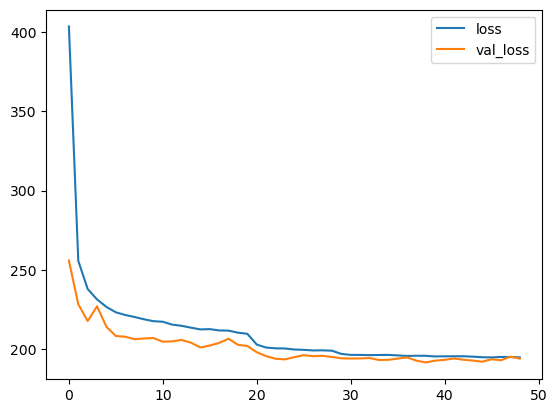

In [28]:
plt.plot(logs.history['loss'], label="loss")
plt.plot(logs.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

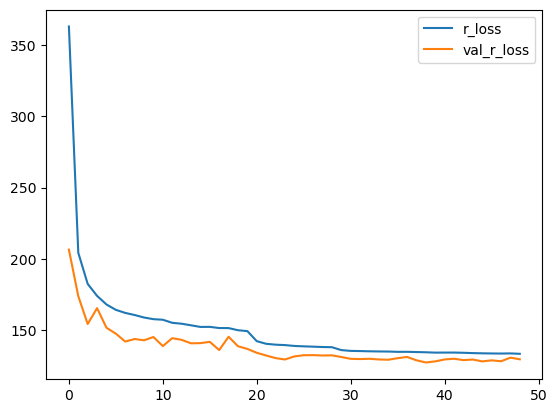

In [29]:
plt.plot(logs.history['r_loss'], label="r_loss")
plt.plot(logs.history['val_r_loss'], label="val_r_loss")
plt.legend()
plt.show()

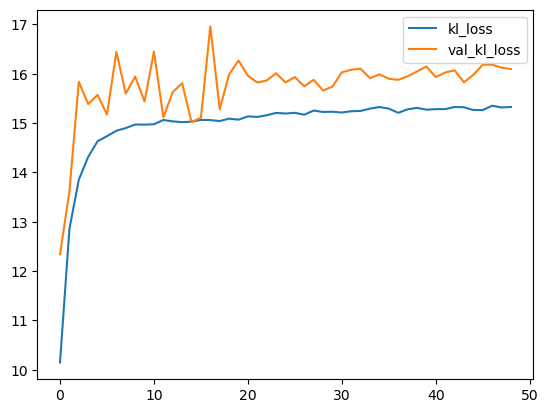

In [30]:
plt.plot(logs.history['kl_loss'], label="kl_loss")
plt.plot(logs.history['val_kl_loss'], label="val_kl_loss")
plt.legend()
plt.show()

# Testing

In [20]:
# optional
# vae = keras.models.load_model(model_path, custom_objects={'Sampling': Sampling}, compile=False)
# vae.summary()

13/13 [==============================] - 1s 19ms/step


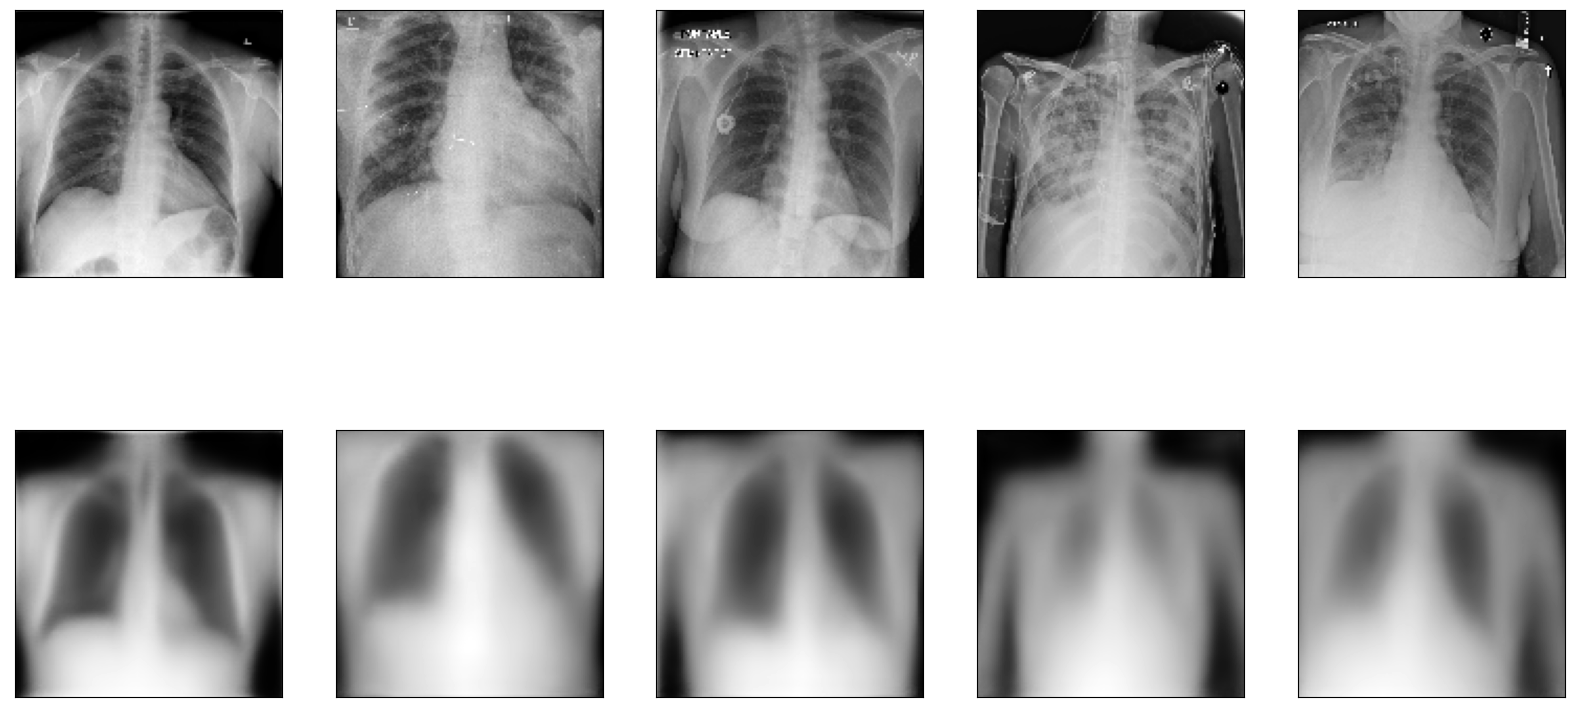

In [21]:
decoded_imgs = vae.predict([X_test, y_test])

n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Plotting the latent space

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [23]:
def plot_latent(encoder, x_test, y_test):
    plt.figure(figsize=(12,12))
    test_latent = encoder.predict([x_test, y_test], verbose=0)[-1]
    pca = PCA(n_components=2)
    test_latent_2d = pca.fit_transform(test_latent)
#    tsne = TSNE(2)
#    test_latent_2d = tsne.fit_transform(test_latent)
    print(test_latent_2d.shape)
    sns.scatterplot(x=test_latent_2d[:,0], y=test_latent_2d[:,1], hue=y_test, palette="tab10")

(10000, 2)


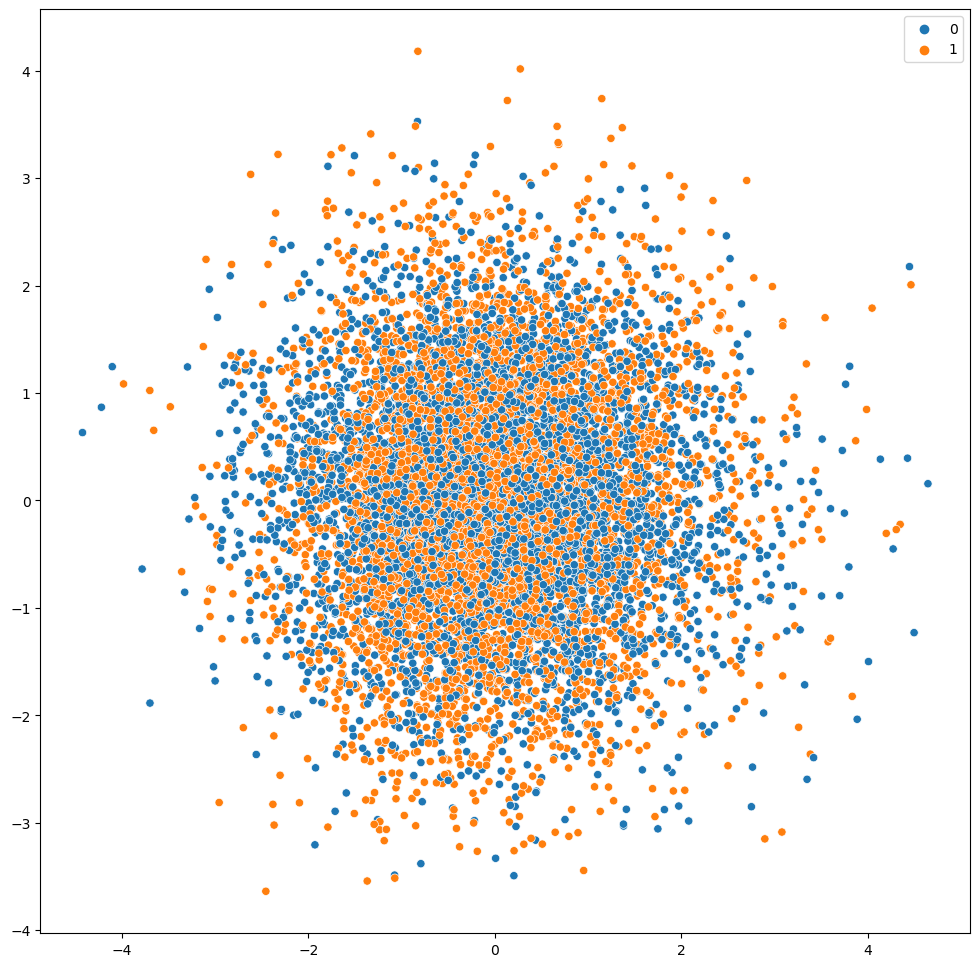

In [24]:
plot_latent(encoder, X_train,y_train) #or X_test,y_test

# Sampling a image from noise

In [25]:
batch = 6
classes = np.array([0,0,0,1,1,1])
ruido = np.random.randn(batch, latent_dim)
gen_imgs = decoder.predict([ruido, classes])
gen_imgs.shape

1/1 [==============================] - 0s 281ms/step


(6, 128, 128, 1)

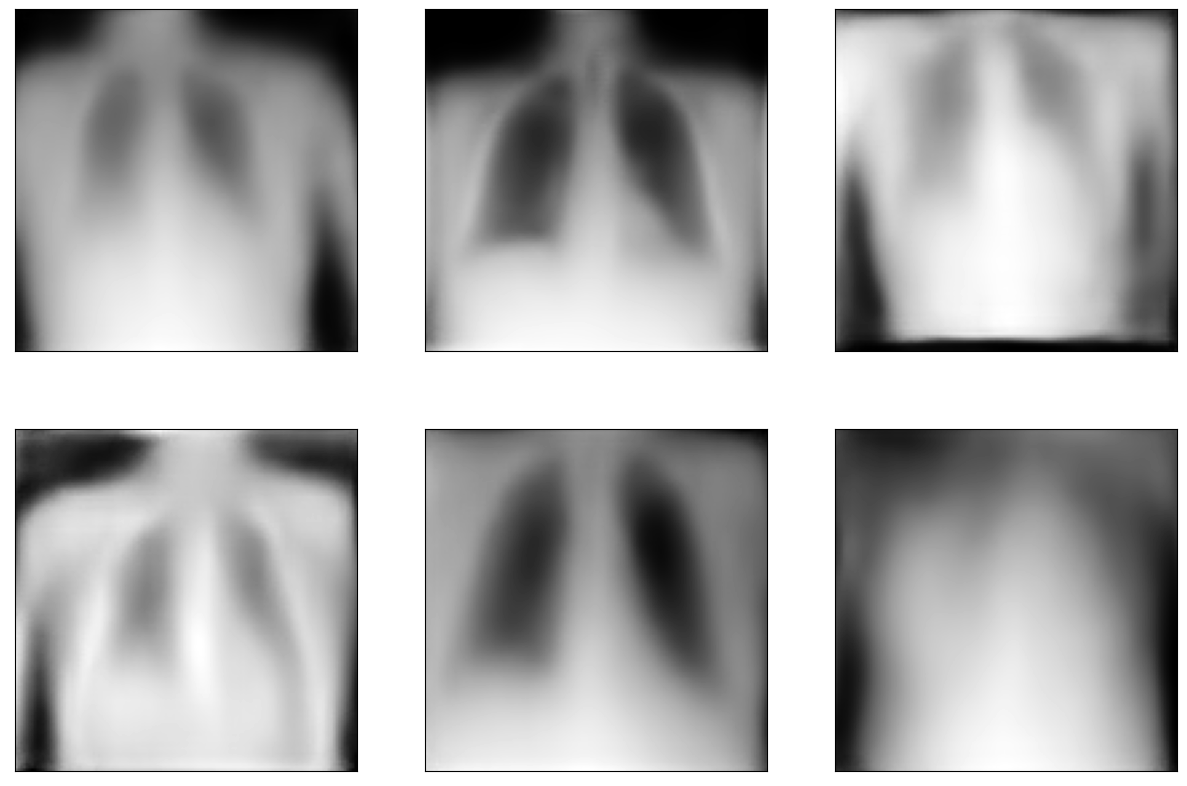

In [26]:
plt.figure(figsize=(15, 10))
for i in range(1,batch+1):
    ax = plt.subplot(2, batch//2, i)
    ax.imshow(np.squeeze(gen_imgs[i-1]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()